___One of the more important aspects of AB testing is explainability to stake-holders. How do you interpret your results? In order to do so, it is necessary to have a fundamental grasp of how the algorithm works.
To clarify it we will be lookinag at two different ways to how we can reach our conclusions from the T Test___:
- P-value 
- Confidence Interval

Taking the example from last notebook,

In [104]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns 
sns.set_style('darkgrid')
random.seed(30)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

__Generate Data:__

In [105]:
def generate_data(sample_number):
    revenue_per_user_range = np.arange(50, 100, 0.012)
    #Note THIS IS NOT the Randomization unit. I am just assigning 1000 'users' with random revenue-per-user quantities from the above list
    control = random.choices(revenue_per_user_range, k=sample_number)
    treatment = random.choices(revenue_per_user_range, k=sample_number)
    return control,treatment

control,treatment  = generate_data(1000)

## Stating the Hypothesis: 
It is important to state the hypothesis before the experiment. THat would lead to decrease in any bias that may come along.
Since we tested a new method, we will assume that it will lead to a difference. __Since, We do not know that it will lead to a positive change, we are going to assume that there will be a change in mean but not in which direction (better or worse).__ _This would depend on whatever the goal is, and the choice of one-tailed_ 

Then we formally, formulate our hypothesis.

Here, <br>
Our Null hypothesis is that, there is no difference in the means of the revenue-per-user between the Control and Treatment.<br>
Our Alternate hypotheis is that, there is a difference in the means of the revenue-per-user between the Control and Treatment.

<font size="4">
$H_{0}$ : $Mean_{Control} = Mean_{Treatment}$ <br>
$H_{A}$ : $Mean_{Control} \neq Mean_{Treatment}$
</font>
<br>
<br>

<font size="1">Note: A one-tailed test is where you are only interested in one direction. <br>
_One-tailed test, <br>  

</font>
    
<font size="3">$H_{A}$ : $Mean_{Control} > Mean_{Treatment}$ <br> OR $Mean_{Control}$ < $Mean_{Treatment}$</font>


## Simple EDA

Doing some plots is always an easy way to visually get an idea of how the experiment went (specially when you have a larger number of variants. First we start with a KDE plot which is Kernel Density Plot(probability Density of a continuous variable).

__Note__: _While kernel density estimation produces a probability distribution, the height of the curve at each point gives a density, not a probability. A probability can be obtained only by integrating the density across a range._

We are also going to do a box plot as well as swarm plot to see the observations of the data. 

In [167]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

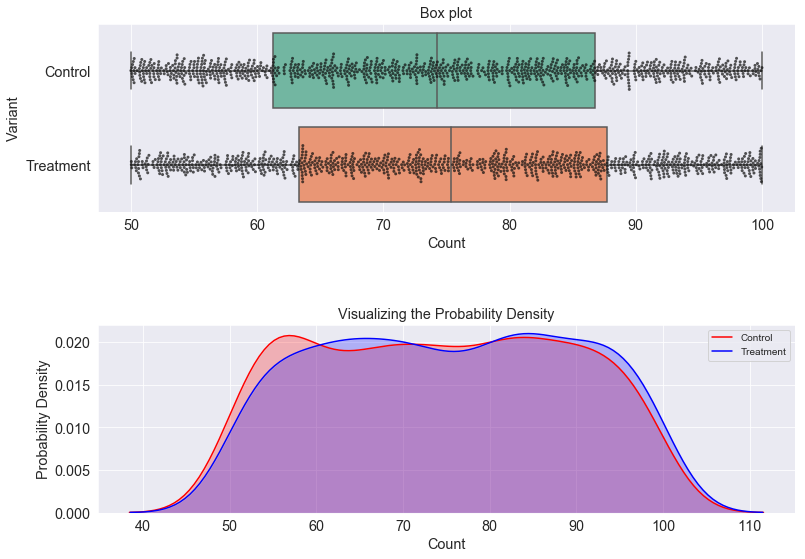

In [168]:
f, (ax1, ax2) = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.6)

sns.boxplot(data=[control,treatment], orient="h", palette="Set2", ax=ax1)
sns.swarmplot(data=[control,treatment],orient="h", color=".05", size=3, alpha=0.7, ax=ax1)

#sns.catplot(data=[control,treatment],orient="h",  ax=ax1)
ax1.set_yticklabels(['Control','Treatment'])
ax1.set_ylabel('Variant')
ax1.set_xlabel('Count')
ax1.set_title('Box plot')

sns.kdeplot(data=control, color='r', shade=True, label = 'Control', ax=ax2)
sns.kdeplot(data=treatment, color='b', shade=True, label = 'Treatment', ax=ax2)
ax2.set_ylabel('Probability Density')
ax2.set_xlabel('Count')
plt.title('Visualizing the Probability Density')
plt.legend()

In Hypothesis testing, plots definitely help us give a bigger picture of the experiment. However, statistical testing is essential in assisting with decision-making.

***

# T-test


One of the most common methods of calculating significance in Controlled Online Experiments is __T-test__.

To reiterate from the previous chapter, T-test __compares the mean of two difference samples__ with consideration to the variance of them, ultimately giving the significance of how different they are from each other. Welch's T-test differs from Student's T-test in the assumption of variances. Student's t-test assumes that the variance is the same for both the sample whereas Welch's T-test assumes unequal variances. Here we focus on independent samples T test meaning that the data we observe is from difference samples (no cross over or leakage) _more on this later_.

<u>__Student's T test:__</u>

<font size="6">$ t = \frac{\bar{X}_{1} - \bar{X}_{2} }{\sqrt{s^{2}({ \frac{1}{N_{1}} + \frac{1}{N_{2}})}}} $</font>

<u>__Welch's T test:__</u>

<font size="6">$ t = \frac{\bar{X}_{1} - \bar{X}_{2} }{\sqrt{\frac{s_{1}^{2}}{N_{1}} + \frac{s_{2}^{2}}{N_{2}}}} $</font>

where, <br>
- $\bar{X}$ =  sample mean
- $s$ = standard deviation
- $N$ = sample size


__Practically, Welch's T-test is just equal to Student's T-test if the variances are equal.__ Personally, I would use Welch's t-test just because it catches the error if the variances are not equal.

Intuitively, The larger the t score, the more difference there is between groups. The smaller the t score, the more similarity there is between groups.


In [169]:
control_mean = np.mean(control)
treatment_mean = np.mean(treatment)
control_stddev = np.std(control)
treatment_stddev = np.std(treatment)
N = 1000

In [170]:
print(control_mean)

74.33112800000093


In [171]:
print(treatment_mean)

75.43929200000098


In [172]:
relative_difference = (np.mean(treatment) - np.mean(control)) / np.mean(control)* 10
observed_t = (treatment_mean - control_mean)/ sqrt( (control_stddev)**2/N + (treatment_stddev)**2/N )


print('The relative improvement from control to treatment was: ', relative_difference)
print('The observed t-statistic from the test was:', observed_t)

The relative improvement from control to treatment was:  0.14908478181577317
The observed t-statistic from the test was: 1.7115930278588054


***

We can see that the t value we got from our T test is 1.321. To interpret this, let us see the T distribution. 

The t-distribution is symmetric and bell-shaped, like the normal distribution, but has heavier tails, meaning that it is more prone to producing values that fall far from its mean. 

Normally, where x is the sample mean, μ is the population mean, s is the standard deviation of the sample, n is the sample size, the degrees of freedom are equal to n - 1. 

__The t-distribution centers on zero because it assumes that the null hypothesis is true and is the approximation of a normal distribution. When the null is true, your study is most likely to obtain a t-value near zero and less liable to produce t-values further from zero in either direction__


The degrees of freedom in a statistical calculation represent how many values involved in a calculation have the freedom to vary. There are multiple ways to infer the value for this. A general rule of thumb is 'N-1' which accounts for the number of samples minus 1. But we are going to use the formula formula for it. 

<font size="6">$$df = \frac{\left [ \frac{s_{1}^{2} }{n_{1}} + \frac{s_{2}^{2} }{n_{2}} \right ]^{2}}{\frac{\left (\frac{s_{1}^{2}}{n_{1}}\right )^{2}}{n_{1}-1} + \frac{\left (\frac{s_{2}^{2}}{n_{2}} \right )^{2}}{n_{2}-1}}$$</font>


This formula uses all the values we have already seen.

In [173]:
top =  (control_stddev)**2/N + (treatment_stddev)**2/N 
bottom1 = 1/(N-1)*(control_stddev**2/N)
bottom2 = 1/(N-1)*(treatment_stddev**2/N)

In [174]:
df = top/(bottom1+bottom2)
df

999.0000000000001

# Visualizing the T -distribution: 
T-distribution is the probability density function of t statistic. Here we use the degrees of freedom as 999 which we calculated from the above formula.


As the t-distribution approaches larger degrees of freedom, it has the same values as the [z-distribution](https://www.dummies.com/education/math/statistics/using-the-z-distribution-to-find-the-standard-deviation-in-a-statistical-sample/)

The probability density function* for t-distribution is given by this __indimidating equation__ : 

<font size="6">$$f(t) = \frac{\Gamma(\frac{\nu+1}{2})} {\sqrt{\nu\pi}\,\Gamma(\frac{\nu}{2})} \left(1+\frac{t^2}{\nu} \right)^{\!-\frac{\nu+1}{2}}\!$$</font>


where, <br>
$\nu$  is the number of degrees of freedom and <br>
$\Gamma$  is the gamma function. $\Gamma = {\displaystyle \Gamma (n)=(n-1)!\ .}$ <br>


_In probability theory, a probability density function*, or density of a continuous random variable, is a function whose value at any given sample in the sample space can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample._

So the basic steps we have followed till now:
- Find the t-statistic
- Find the degrees of freedom

Now,
- We refer to the t-distribution table and find our critical thresholds
- Then compare it with our observed t-statistic 
- Find the corresponding p-value and accept or reject the null hypothesis 

__The Critical Thresholds that is conventionally chosen is 95% confidence interval or (p-value = 0.05)__

<div>
    <center>
    <img src="images/fig-2.png" width="500"/>
        <br>
     <text><b> Fig 2: T-distribution reference table</b> <br> 
         <i> (Source: https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)</i>
     </text>
    </center>
</div>


Here, we can see that our threshold corresponds with 

# P-value method:

If the p-value is less than the significance value (alpha value) we can reject the null hypothesis.

The P value is the corresponding cumulative distribution function of the observed t-value.

In [175]:
p=(1-t.cdf(observed_t, df))*2

print('The observed p-value from the test was:', p )


The observed p-value from the test was: 0.08728208092758383


In [176]:
stats.norm.pdf(observed_t)

0.09220749327931005

Text(0.5, 1.0, 'Null distribution')

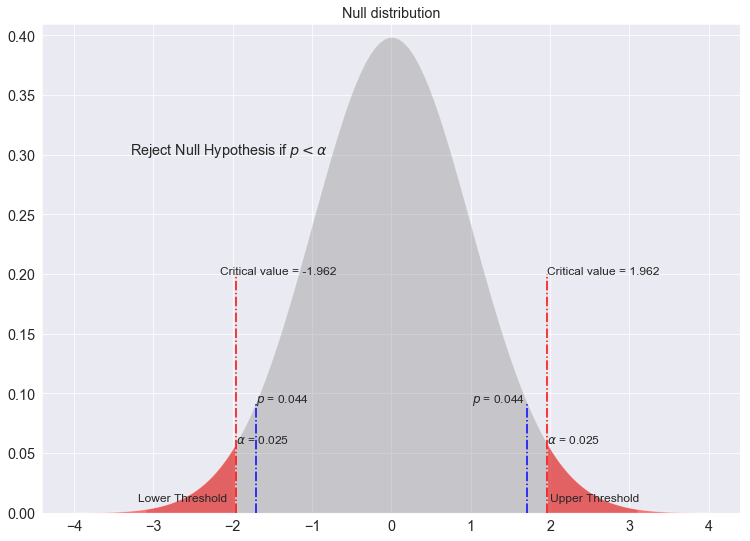

In [206]:
from scipy.stats import norm
from scipy.stats import t
f, ax = plt.subplots(1)
ax.set_ylim(bottom=0,top=0.41)

df = 999

#stats.norm.pdf(np.arange(-4,-2,0.01)

plt.plot((observed_t, observed_t), (0, stats.norm.pdf(observed_t)), color='b', linestyle='-.')
plt.plot((-observed_t, -observed_t), (0, stats.norm.pdf(observed_t)), color='b', linestyle='-.')


plt.plot((-1.962, -1.962), (0, 0.2), color='r', linestyle='-.')
plt.plot((1.962, 1.962), (0, 0.2), color='r', linestyle='-.')

x = np.linspace(t.ppf(0.001, df),
                t.ppf(0.999, df), 100)

plt.fill_between(x=x, 
                 y1= stats.norm.pdf(x) ,
                 facecolor='grey',
                 alpha=0.35)

#upper threshold

plt.fill_between(x=np.arange(-4,-1.962,0.01),
                 y1= stats.norm.pdf(np.arange(-4,-1.962,0.01)),
                 facecolor='red',
                 alpha=0.5)              

plt.fill_between(x=np.arange(1.962,4,0.01), 
                 y1= stats.norm.pdf(np.arange(1.962,4,0.01)),
                 facecolor='red',
                 alpha=0.5)

#texts
#plt.text(x=-1, y=0.1, size='x-large', s= "95% confidence interval")
plt.text(x=-3.2, y=0.01, size='large', s= "Lower Threshold")
plt.text(x=2, y=0.01, size='large', s= "Upper Threshold")
plt.text(x=1.962, y=0.2, size='large', s= "Critical value = 1.962")
plt.text(x=-1.962-0.2, y=0.2, size='large', s= "Critical value = -1.962")

plt.text(x=observed_t-0.7, y=stats.norm.pdf(observed_t), size='large', s= f"$p$ = {round(p/2,3)}")
plt.text(x=-observed_t, y=stats.norm.pdf(observed_t), size='large', s= f"$p$ = {round(p/2,3)}")

plt.text(x=1.962, y=stats.norm.pdf(1.962), size='large', s=r'$\alpha$ = 0.025')
plt.text(x=-1.962, y=stats.norm.pdf(1.962), size='large', s=r'$\alpha$ = 0.025')

plt.text(x=-3.3,y=0.3,size='x-large', s =r'Reject Null Hypothesis if $p < \alpha$')
plt.title('Null distribution')

Text(1.7, 0.01, 'Upper Threshold')

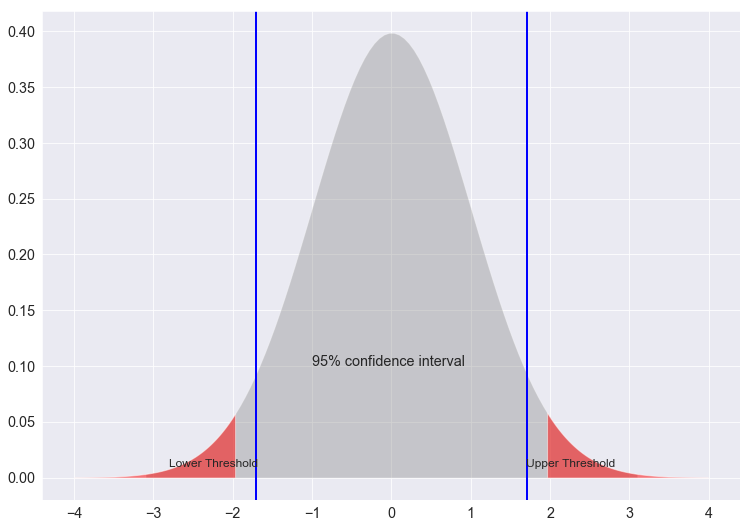

In [178]:
from scipy.stats import norm
from scipy.stats import t


#from z table, the area is 0.9066 > 0.05 so null hypothesis 

df = 999



#stats.norm.pdf(np.arange(-4,-2,0.01)



'''
plt.fill_between(x=np.arange(-observed_t,observed_t,0.01),
                 y1= stats.norm.pdf(np.arange(-observed_t,observed_t,0.01)),
                 facecolor='blue',
                 alpha=0.5)      
'''



plt.axvline(x= observed_t, color = "blue", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))
plt.axvline(x= -observed_t, color = "blue", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))


x = np.linspace(t.ppf(0.001, df),
                t.ppf(0.999, df), 100)

plt.fill_between(x=x, 
                 y1= stats.norm.pdf(x) ,
                 facecolor='grey',
                 alpha=0.35)

#upper threshold
plt.fill_between(x=np.arange(-4,-1.962,0.01),
                 y1= stats.norm.pdf(np.arange(-4,-1.962,0.01)),
                 facecolor='red',
                 alpha=0.5)              
#lower threshold
plt.fill_between(x=np.arange(1.962,4,0.01), 
                 y1= stats.norm.pdf(np.arange(1.962,4,0.01)),
                 facecolor='red',
                 alpha=0.5)

plt.text(x=-1, y=0.1, size='x-large', s= "95% confidence interval")
plt.text(x=-2.8, y=0.01, size='large', s= "Lower Threshold")
plt.text(x=1.7, y=0.01, size='large', s= "Upper Threshold")

# Confidence Interval Method:
__If zero lies outside of the observed confidence interval of the observed distribution, we can reject the null hypothesis.__

In [12]:
np.mean(treatment) - np.mean(control)

1.1081640000000448

In [13]:
control_mean = np.mean(control)
treatment_mean = np.mean(treatment)
control_stddev = np.std(control)
treatment_stddev = np.std(treatment)

standard_error = np.sqrt( ( control_stddev**2/1000) + (treatment_stddev**2/1000) ) 
d = np.mean(treatment) - np.mean(control)

t_critical = 1.962
high= d+(t_critical*standard_error)
low = d-(t_critical*standard_error)

In [14]:
d

1.1081640000000448

In [15]:
high, low

(2.378452983777937, -0.16212498377784756)

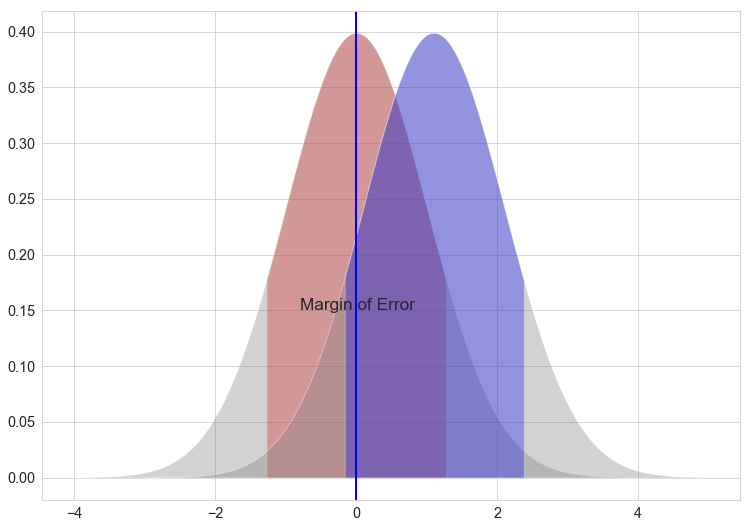

In [62]:
from scipy.stats import norm
from scipy.stats import t
#from z table, the area is 0.9066 > 0.05 so null hypothesis 
df = 999
#stats.norm.pdf(np.arange(-4,-2,0.01)


#plt.axvline(x= high, color = "blue", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))
#plt.axvline(x= low, color = "blue", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))

plt.axvline(x= 0, color = "blue", linewidth = 2, label=f'True Mean: ' + "%.2f" % np.mean(control))
plt.fill_between(x=np.arange(-1.962*standard_error,1.962*standard_error,0.01), 
                 y1= stats.norm.pdf(np.arange(-1.962*standard_error,1.962*standard_error,0.01)) ,
                 facecolor='red',
                 alpha=0.35)


plt.text(x=-0.8, y=0.15,size='xx-large',s= "Margin of Error")

plt.fill_between(x=np.arange(-4,4,0.01), 
                 y1= stats.norm.pdf(np.arange(-4,4,0.01)) ,
                 facecolor='grey',
                 alpha=0.35)

#observed result
plt.fill_between(x=np.arange(-3,5,0.01), 
                 y1= stats.norm.pdf(np.arange(-3,5,0.01),loc=1.10) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(low,high,0.01), 
                 y1= stats.norm.pdf(np.arange(low,high,0.01), loc=1.10) ,
                 facecolor='blue',
                 alpha=0.3)




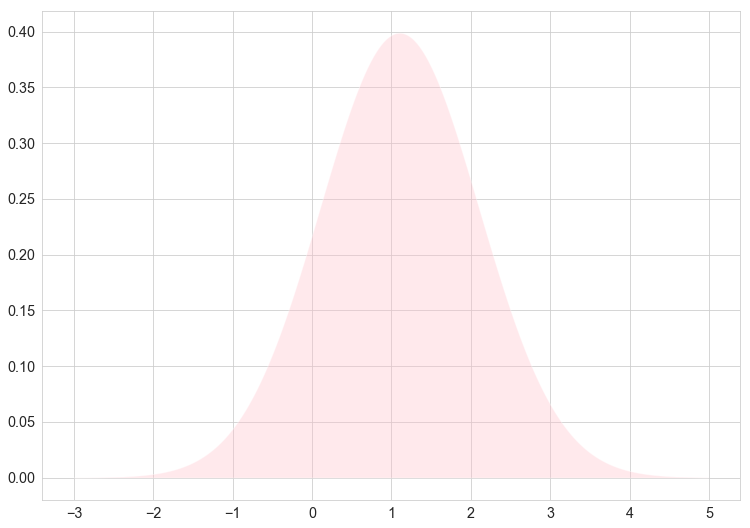

In [17]:
plt.fill_between(x=np.arange(-3,5,0.01), 
                 y1= stats.norm.pdf(np.arange(-3,5,0.01),loc=1.10) ,
                 facecolor='pink',
                 alpha=0.35)

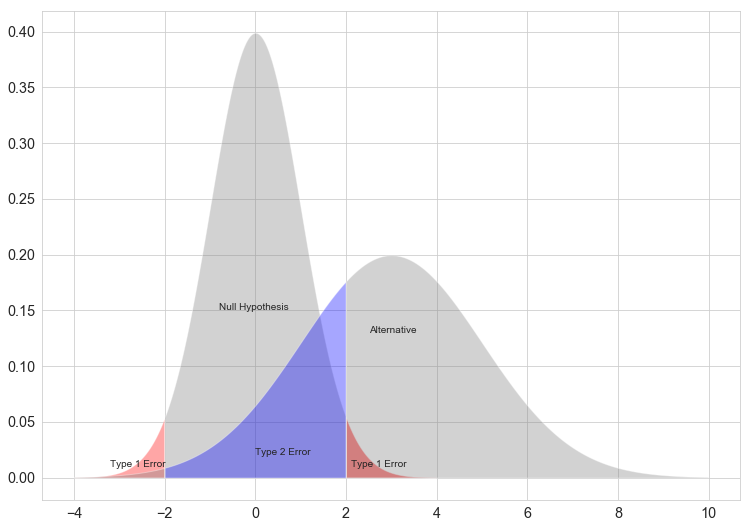

In [18]:
plt.fill_between(x=np.arange(-4,-2,0.01), 
                 y1= stats.norm.pdf(np.arange(-4,-2,0.01)) ,
                 facecolor='red',
                 alpha=0.35)

plt.fill_between(x=np.arange(-2,2,0.01), 
                 y1= stats.norm.pdf(np.arange(-2,2,0.01)) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(2,4,0.01), 
                 y1= stats.norm.pdf(np.arange(2,4,0.01)) ,
                 facecolor='red',
                 alpha=0.5)

plt.fill_between(x=np.arange(-4,-2,0.01), 
                 y1= stats.norm.pdf(np.arange(-4,-2,0.01),loc=3, scale=2) ,
                 facecolor='grey',
                 alpha=0.35)

plt.fill_between(x=np.arange(-2,2,0.01), 
                 y1= stats.norm.pdf(np.arange(-2,2,0.01),loc=3, scale=2) ,
                 facecolor='blue',
                 alpha=0.35)

plt.fill_between(x=np.arange(2,10,0.01), 
                 y1= stats.norm.pdf(np.arange(2,10,0.01),loc=3, scale=2),
                 facecolor='grey',
                 alpha=0.35)

plt.text(x=-0.8, y=0.15, s= "Null Hypothesis")
plt.text(x=2.5, y=0.13, s= "Alternative")
plt.text(x=2.1, y=0.01, s= "Type 1 Error")
plt.text(x=-3.2, y=0.01, s= "Type 1 Error")
plt.text(x=0, y=0.02, s= "Type 2 Error");

In [19]:
import pandas as pd 
df = pd.DataFrame()
df['control'] = control
df['treatment'] = treatment

In [20]:
df.control.mean()

74.33112800000093

In [21]:
df.treatment.mean()

75.43929200000098

In [22]:
df.control.std()

14.520859315718848

In [23]:
df.treatment.std()

14.448201566536198

In [24]:
df['difference'] = df['control'] - df['treatment']

In [25]:
df = ()

# Statistical Power